### Configure the Spark Context

In [2]:
def setupSpark():
  # Spark needs to run with Java 8 ... 
  !pip install -q findspark
  !apt-get install openjdk-8-jdk-headless > /dev/null
  !echo 2 | update-alternatives --config java > /dev/null
  !wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
  !tar xf spark-3.1.2-bin-hadoop3.2.tgz
  # !java -version
  import os, findspark
  os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-8-openjdk-amd64'
  os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"
  # !echo JAVA_HOME=$JAVA_HOME
  !pip install -q pyspark
  findspark.init()
  !pyspark --version


setupSpark()

  Preparing metadata (setup.py) ... done
Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.1.2
      /_/
                        
Using Scala version 2.12.10, OpenJDK 64-Bit Server VM, 1.8.0_362
Branch HEAD
Compiled by user centos on 2021-05-24T04:27:48Z
Revision de351e30a90dd988b133b3d00fa6218bfcaba8b8
Url https://github.com/apache/spark
Type --help for more information.


In [3]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
    
spark = SparkSession\
        .builder\
        .master('local[*]')\
        .getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("WARN")

## Read in Dataset

In [4]:
from pyspark.sql.functions import *

In [5]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
filePath = "drive/MyDrive/Colab Notebooks/comments.csv.xls"
comments_df = spark.read.format("csv").option("header","true").load(filePath)


In [7]:
## push comments to textfile
comments = comments_df.toPandas()
comments["comment_text"].to_csv('drive/MyDrive/Colab Notebooks/comments.txt', sep="\n", index=False)

In [ ]:
comments_df.printSchema()

root
 |-- username_href: string (nullable = true)
 |-- view_key: string (nullable = true)
 |-- comment_text: string (nullable = true)
 |-- upvotes: string (nullable = true)
 |-- timestamp: string (nullable = true)



In [ ]:
## upvotes is a string, we want it to be an int
comments_df = comments_df.withColumn('upvotes', col('upvotes').cast('int'))

In [ ]:
comments_df.printSchema()

root
 |-- username_href: string (nullable = true)
 |-- view_key: string (nullable = true)
 |-- comment_text: string (nullable = true)
 |-- upvotes: integer (nullable = true)
 |-- timestamp: string (nullable = true)



## Exploratory Data Analysis

### Average Upvote Number

In [ ]:
import pandas as pd
import pyspark as ps

In [ ]:
## mode of upvotes
comments_df.groupby("upvotes").count().orderBy("count", ascending=False).show()

+-------+------+
|upvotes| count|
+-------+------+
|      0|319914|
|      1|165434|
|      2| 78840|
|      3| 47820|
|   null| 38887|
|      4| 32103|
|      5| 23187|
|      6| 17890|
|      7| 13707|
|      8| 11220|
|      9|  9186|
|     10|  7585|
|     11|  6438|
|     12|  5525|
|     13|  4810|
|     14|  4378|
|     15|  3849|
|     16|  3524|
|     17|  3148|
|     18|  2972|
+-------+------+
only showing top 20 rows



In [ ]:
# avg of upvotes
comments_df.select(mean('upvotes')).collect()

[Row(avg(upvotes)=8.424066809609668)]

In [ ]:
## log of upvotes

### Unique Comments

In [ ]:
comments_df.select('comment_text').distinct().count()

714965

## Word Frequency

In [8]:
data_file = 'drive/MyDrive/Colab Notebooks/comments.txt'
# take file and distribute it across worker nodes
comments_rdd = sc.textFile(data_file)

In [9]:
comments_rdd.take(20)

['comment_text',
 'Old video...come on pornhub...you can do better than this',
 'Wow 😍',
 'Does anyone know what is the IG account from this channel ?',
 'Clickbait in porn... I just totally lost my faith in humanity.',
 'I would definitely suck a fart out of your asshole!',
 'Super hot, why lie',
 'big toys are fine, but you make me die when you stick your fingers in the A-hole. oh fuck i cummed',
 "This is great. I can't relax in front of the camera like that",
 '❤',
 'love',
 'просто классная девчонка 😍',
 'I’m obsessed!! Your content is amazing 🤫',
 'Amazing content OMG 🔥😍',
 'i love being a lesbian',
 'me too',
 'Better without music.',
 'perfect vid!',
 'Spreads legs love it',
 'Yummy!!!!']

In [10]:
def clean_text(x):
  punc = '!"#$&\'()*+,.:;<=>?@[\\]^_`{|}~-'
  lowercased_str = x.lower()
  for ch in punc:
    lowercased_str = lowercased_str.replace(ch, '')
  return lowercased_str

In [11]:
comments_rdd = comments_rdd.map(clean_text)

In [12]:
comments_rdd.take(20)

['commenttext',
 'old videocome on pornhubyou can do better than this',
 'wow 😍',
 'does anyone know what is the ig account from this channel ',
 'clickbait in porn i just totally lost my faith in humanity',
 'i would definitely suck a fart out of your asshole',
 'super hot why lie',
 'big toys are fine but you make me die when you stick your fingers in the ahole oh fuck i cummed',
 'this is great i cant relax in front of the camera like that',
 '❤',
 'love',
 'просто классная девчонка 😍',
 'i’m obsessed your content is amazing 🤫',
 'amazing content omg 🔥😍',
 'i love being a lesbian',
 'me too',
 'better without music',
 'perfect vid',
 'spreads legs love it',
 'yummy']

In [13]:
# split sentence into word list
comments_rdd = comments_rdd.flatMap(lambda x: x.split(" "))

In [14]:
comments_rdd.take(20)

['commenttext',
 'old',
 'videocome',
 'on',
 'pornhubyou',
 'can',
 'do',
 'better',
 'than',
 'this',
 'wow',
 '😍',
 'does',
 'anyone',
 'know',
 'what',
 'is',
 'the',
 'ig',
 'account']

In [15]:
# exlude any whitespaces
comments_rdd = comments_rdd.filter(lambda x: x != '')

In [16]:
comments_rdd.take(20)

['commenttext',
 'old',
 'videocome',
 'on',
 'pornhubyou',
 'can',
 'do',
 'better',
 'than',
 'this',
 'wow',
 '😍',
 'does',
 'anyone',
 'know',
 'what',
 'is',
 'the',
 'ig',
 'account']

In [17]:
## count
comments_count = comments_rdd.map(lambda word:(word,1))
comments_count.take(5)

[('commenttext', 1),
 ('old', 1),
 ('videocome', 1),
 ('on', 1),
 ('pornhubyou', 1)]

In [18]:
# reduce by key
comments_rbk = comments_count.reduceByKey(lambda x, y:(x+y)).sortByKey()
comments_rbk.take(20)

[('\x100', 1),
 ('%', 27),
 ('%%', 1),
 ('%100', 4),
 ('%15', 1),
 ('%50', 1),
 ('%90', 1),
 ('%appdata%', 6),
 ('%e6%9e%83%e7%80%9b%e6%a5%8b%e7%b4%99%e9%97%88%e5%ad%a6%e7%94%9f%ef%bc%8c%e7%a9%ba%e5%a7%90%e3%80%81%e6%a8%a1%e7%89%b9%e3%80%81%e5%a4%96%ef%bc%88%e7%88%9c%e9%8a%86%e5%82%9d%ef%bc%89%e5%9b%b4%ef%bc%88%e7%88%9c%e9%8a%86%e5%82%9d%ef%bc%89%e5%a5%b3%ef%bc%88%e6%b6%93%e5%93%84%ef%bc%89%e9%a2%84%ef%bc%8c%e7%ba%a6%ef%bc%8c%e7%bd%91%ef%bc%8c%e7%ab%99%ef%bc%9al%20%20%20x%20%20%20s%20%20w%202020%20%ef%bc%88%e7%82%b9%ef%bc%89c%ef%bc%8co%ef%bc%8cm%20%e5%8b%92%20%20%e4%ba%ab%20%e5%95%86%20%e5%8a%a1',
  1),
 ('%e7%b6%8b%e6%9d%88%e6%92%b3%e5%8f%86%e7%bb%be%ee%88%9d%e5%ab%b3%e9%8f%82%e5%ad%a6%e7%94%9f%ef%bc%8c%e7%a9%ba%e5%a7%90%e3%80%81%e6%a8%a1%e7%89%b9%e3%80%81%e5%a4%96%ef%bc%88%e9%97%88%ef%bc%89%e5%9b%b4%ef%bc%88%e9%97%88%ef%bc%89%e5%a5%b3%ef%bc%88%e9%97%88%ef%bc%89%e9%a2%84%ef%bc%8c%e7%ba%a6%ef%bc%8c%e7%bd%91%ef%bc%8c%e7%ab%99%ef%bc%9al%20%20%20x%20%20%20s%20%20w%202020%20%ef%bc%88%e7%82

In [19]:
# rank words in descending order
comments_rbk = comments_rbk.map(lambda x: (x[1],x[0]))
comments_rbk.take(5)

[(1, '\x100'), (27, '%'), (1, '%%'), (4, '%100'), (1, '%15')]

In [20]:
comments_rbk.sortByKey(False).take(20)

[(201269, 'i'),
 (179937, 'the'),
 (141744, 'a'),
 (140830, 'to'),
 (127972, 'you'),
 (122113, 'is'),
 (114712, 'and'),
 (90444, 'this'),
 (85759, 'that'),
 (85645, 'so'),
 (83623, 'her'),
 (78121, 'love'),
 (75518, 'my'),
 (68426, 'of'),
 (67390, 'in'),
 (67007, 'she'),
 (64754, 'it'),
 (64238, 'me'),
 (63040, 'hot'),
 (60888, 'like')]

In [21]:
# now, remove stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [33]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english') + ['00000000', '000000']

In [34]:
comments_rbk = comments_rbk.filter(lambda x: x[1] not in stopwords).sortByKey(False)
comments_rbk.sortByKey(False).take(20)

[(78121, 'love'),
 (63040, 'hot'),
 (60888, 'like'),
 (46163, 'video'),
 (35811, 'fuck'),
 (32933, 'would'),
 (32373, 'pussy'),
 (32365, 'sexy'),
 (29165, 'girl'),
 (28452, 'nice'),
 (27856, 'ass'),
 (25518, 'want'),
 (25164, 'name'),
 (24563, 'good'),
 (24170, 'beautiful'),
 (23189, 'cock'),
 (23134, 'one'),
 (22689, 'fucking'),
 (22390, 'great'),
 (21859, 'amazing')]

In [35]:
# now, plot
top_20_words = comments_rbk.sortByKey(False).take(20)

In [36]:
# create dictionary from list
indexes = [i for i in range(20)][::-1]
labels = [i[1] for i in top_20_words][::-1]
values = [i[0] for i in top_20_words][::-1]

In [37]:
import matplotlib.pyplot as plt

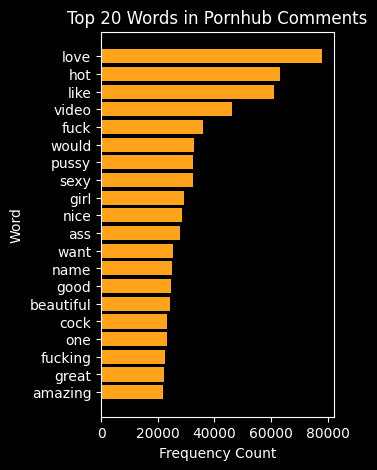

In [48]:
bar_width = 0.35

bar_width = 0.35

fig = plt.figure() 
fig.set_size_inches(3,5)

plt.style.use('dark_background')
plt.barh(indexes, values, color='#ffa31a')

# add labels
plt.yticks(indexes, labels, fontsize=10, color='white')
plt.xlabel('Frequency Count', fontsize=10, color='white')
plt.ylabel('Word', fontsize=10)
plt.title('Top 20 Words in Pornhub Comments', fontsize=12, color='white')
plt.gca().invert_yaxis()
plt.show()

In [39]:
# now, plot wordclouds
top_50_words = comments_rbk.sortByKey(False).take(50)

In [40]:
words = {
    i[1]: i[0] for i in top_50_words
}

In [42]:
words

{'love': 78121,
 'hot': 63040,
 'like': 60888,
 'video': 46163,
 'fuck': 35811,
 'would': 32933,
 'pussy': 32373,
 'sexy': 32365,
 'girl': 29165,
 'nice': 28452,
 'ass': 27856,
 'want': 25518,
 'name': 25164,
 'good': 24563,
 'beautiful': 24170,
 'cock': 23189,
 'one': 23134,
 'fucking': 22689,
 'great': 22390,
 'amazing': 21859,
 'cum': 21350,
 'get': 18919,
 'im': 18451,
 'see': 18411,
 'videos': 18259,
 'dick': 18080,
 'wow': 17650,
 'please': 16342,
 '🙂': 16123,
 'perfect': 15764,
 'really': 15270,
 'shes': 15094,
 'damn': 14818,
 'best': 14580,
 'know': 14458,
 'thank': 14409,
 '😉': 14267,
 'need': 13822,
 'make': 13247,
 'guy': 13112,
 'porn': 13061,
 'wish': 12587,
 'thanks': 12429,
 'much': 12145,
 'guys': 12136,
 'body': 11975,
 'hard': 11942,
 'big': 11859,
 'got': 11629,
 'time': 11456}

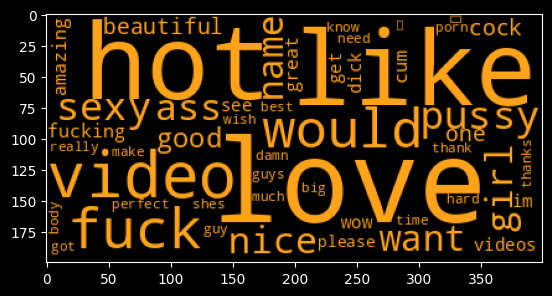

In [49]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import ChainMap
import pyspark.sql.functions as F

wordcloud = WordCloud(background_color="black",  color_func=lambda *args, **kwargs: "#ffa31a")

plt.imshow(wordcloud.generate_from_frequencies(words))

plt.show()